In [1]:
import pandas as pd
import os
import plotly.graph_objects as go
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from vendi_score import vendi
os.chdir("..")

In [2]:

# Volver a cargar las subsamples
def load_subsamples(dataset_name, dim):
    pickle_file_path = f"data/subsamples/{dataset_name}_{dim}_subsamples.pkl"
    with open(pickle_file_path, "rb") as f:
        subsamples = pickle.load(f)
    
    return subsamples


def create_plot_for_dataset(dataset_name, dataset, source_subsamples):
    whole_data = dataset.groupby("source").agg(
        reliability=("reliability", "first"),  
        bias=("bias", "first"),     
        count=("source", "size")
    ).reset_index()

    total_count_whole = whole_data['count'].sum()  # Total count of all sources
    whole_data['proportion'] = whole_data['count'] / total_count_whole 

    # Normalize bubble sizes 
    max_bubble_size = 50  
    whole_data['normalized_size'] = (whole_data['count'] / whole_data['count'].max()) * max_bubble_size


    subset_data = source_subsamples  
    # Extract subset names and sort by vs 
    subset_names_sorted = sorted(subset_data.keys(), key=lambda name: subset_data[name]['vs'])

    # Create frames for each subset
    frames = []
    for subset_name in subset_names_sorted:
        subset_df = subset_data[subset_name]['data'].groupby("source").agg(
            reliability=("reliability", "first"),  
            bias=("bias", "first"),     
            count=("source", "size")
        ).reset_index()

        total_count = subset_df['count'].sum()
        subset_df['proportion'] = subset_df['count'] / total_count

        # Merge with the whole dataset
        merged_data = whole_data.merge(subset_df, on='source', how='left', suffixes=('_x', '_y'))

        merged_data['count_y'] = merged_data['count_y'].fillna(0)
        merged_data['proportion_y'] = merged_data['proportion_y'].fillna(0)

        # Normalize bubble sizes 
        merged_data['normalized_size'] = (merged_data['count_y'] / merged_data['count_y'].max()) * max_bubble_size

        # Create the frame for the subset
        frame = go.Frame(
            data=[go.Scatter(
                x=merged_data['bias_x'],  
                y=merged_data['reliability_x'],  
                mode='markers',
                text=merged_data['source'],
                hovertext=merged_data['source'], 
                hoverinfo='text',
                marker=dict(
                    size=merged_data['normalized_size'],
                    color=merged_data['proportion_y'], 
                    colorscale='Redor',  
                    cmin=0,              
                    cmax=1,             
                    showscale=True,     
                    colorbar=dict(
                        title='Proportion',
                        tickformat=".2f"
                    )
                )
            )],
            name=subset_name
        )
        frames.append(frame)

    # Base figure with the whole dataset
    fig = go.Figure(
        data=[go.Scatter(
            x=whole_data['bias'],  
            y=whole_data['reliability'],  
            mode='markers',  
            hovertext=whole_data['source'],  
            hoverinfo='text',  
            marker=dict(
                size=whole_data['normalized_size'],
                color='gray',
                opacity=0.5
            ),
            name="Whole Dataset"
        )],
        frames=frames
    )

    vs_values = [subset_data[name]['vs'] for name in subset_names_sorted]
    vs_min, vs_max = min(vs_values), max(vs_values)

    slider_steps = [
        {
            "label": f"VS: {vs:.2f}",
            "method": "animate",
            "args": [[subset_name], {"frame": {"duration": 500, "redraw": True}, "mode": "immediate"}],
        }
        for subset_name, vs in zip(subset_names_sorted, vs_values)
    ]

    sliders = [{
        "active": 0,
        "pad": {"t": 50},
        "steps": slider_steps
    }]

    x_min, x_max = -42, 42
    y_min, y_max = 0, 64

    # Configure layout
    fig.update_layout(
        title=f"Source subsamples by diversity measure for {dataset_name}",
        xaxis=dict(title="Bias", range=[x_min, x_max]),  
        yaxis=dict(title="Reliability", range=[y_min, y_max]),  
        updatemenus=[{
            "type": "buttons",
            "showactive": True,
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]
                },
                {
                    "label": "Pause",
                    "method": "animate",
                    "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]
                }
            ]
        }],
        sliders=sliders
    )

    fig.frames = frames
    fig.show()


In [3]:
datasets = {
    "annomatic": pd.read_parquet("data/enriched/annomatic_topics.parquet"),
    "babe": pd.read_parquet("data/enriched/babe_topics.parquet"),
    "basil": pd.read_parquet("data/enriched/basil_topics.parquet")
}

for dataset_name, df in datasets.items():
    source_subsamples = load_subsamples(dataset_name, "source")  
    create_plot_for_dataset(dataset_name, df, source_subsamples)

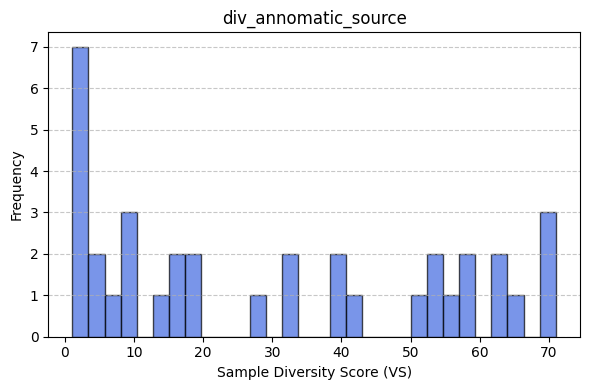

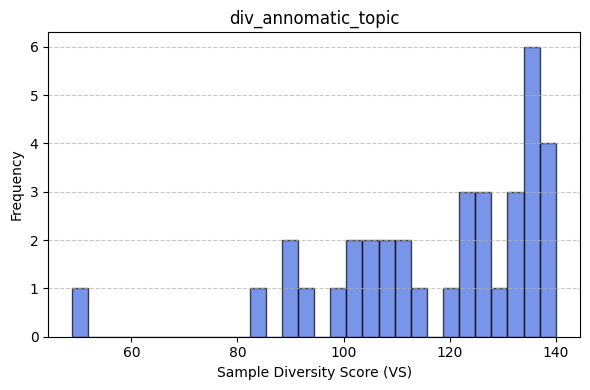

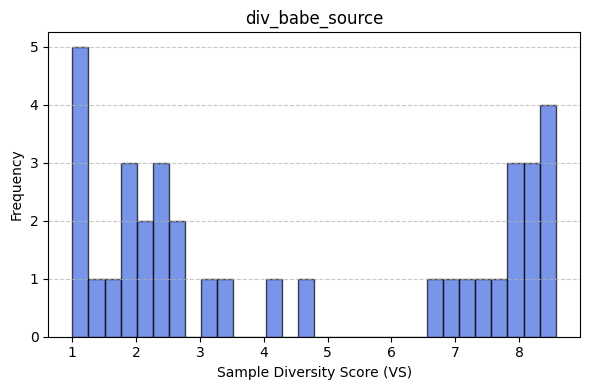

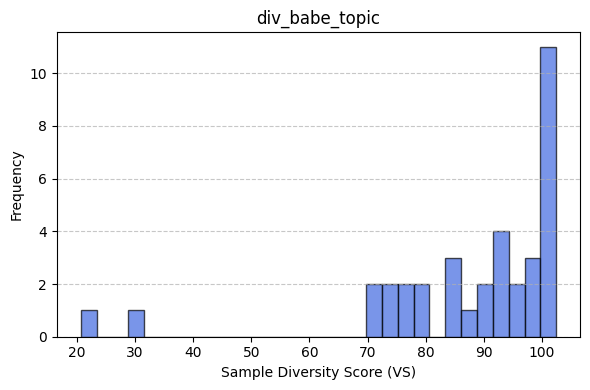

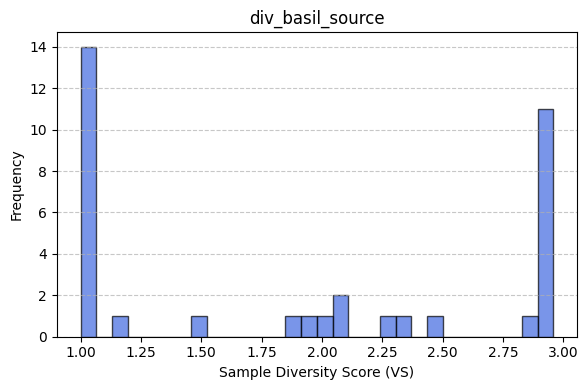

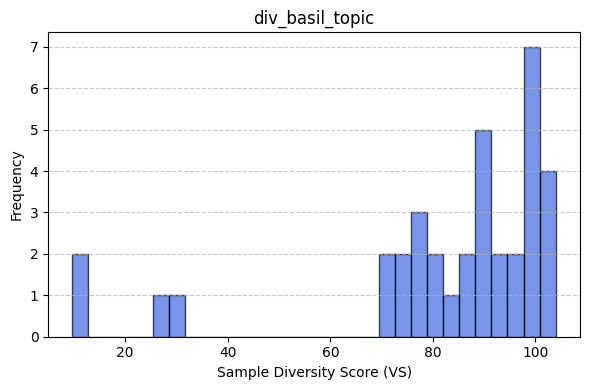

In [4]:
import matplotlib.pyplot as plt

folder_path = "data/subsamples"
dataframes = {}

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  #
        file_path = os.path.join(folder_path, file) 
        df = pd.read_csv(file_path) 
        key = os.path.splitext(file)[0] 
        dataframes[key] = df 

def plot_hist_vs(df, name):
    plt.figure(figsize=(6, 4))
    plt.hist(df["vs"], bins=30, color='royalblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Sample Diversity Score (VS)')
    plt.ylabel('Frequency')
    plt.title(name)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

for name, df in dataframes.items():
    plot_hist_vs(df, name)


Cannot really control VS score for topic. Diversity inside topics can be high, when selecting more than one also explodes.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np
from vendi_score import vendi
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import matplotlib.pyplot as plt
import random


def vendi_score_topic(df, embedding_column):
    """
    Calculate Vendi Score for topic using cosine similarity between topic embeddings.
    """
    #df = df.dropna(subset=[embedding_column])  # Drop rows where embedding is NaN

    # Stack the embeddings into a matrix (n_samples, embedding_dim)
    embeddings = np.stack(df[embedding_column].values)

    # Compute the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(embeddings)
    vendi_score = vendi.score_K(cosine_sim_matrix)

    return vendi_score

vendi_scores = {}


for dataset_name, df in datasets.items():
    topic_scores = {}
    grouped = df.groupby('topic')

    for topic, group in grouped:
        score = vendi_score_topic(group, embedding_column='sentence_embedding') 
        topic_scores[topic] = score

    vendi_scores[dataset_name] = topic_scores

# Display the scores
for dataset_name, scores in vendi_scores.items():
    print(f"Vendi Scores for {dataset_name}:")
    for topic, score in scores.items():
        print(f"  Topic: {topic}, Vendi Score: {score:.2f}")   

Vendi Scores for annomatic:
  Topic: 0_israel_hamas_gaza_israeli, Vendi Score: 56.30
  Topic: 100_protests_riots_protest_streets, Vendi Score: 19.23
  Topic: 101_fox_fox news_click fox_news app, Vendi Score: 13.86
  Topic: 102_napoleon_scott_ridley_ridley scott, Vendi Score: 14.61
  Topic: 103_amendment_speech_amendment rights_censorship, Vendi Score: 18.21
  Topic: 104_film_wilson_hader_actor, Vendi Score: 56.09
  Topic: 105_portman_cast_actress_nina, Vendi Score: 46.11
  Topic: 106_housing_san francisco_francisco_san, Vendi Score: 30.37
  Topic: 107_google_apple_apps_search, Vendi Score: 34.21
  Topic: 108_african_africa_apartheid_anc, Vendi Score: 18.69
  Topic: 109_space_circle_space station_international space, Vendi Score: 25.13
  Topic: 10_hotel_museum_hotels_beach, Vendi Score: 79.16
  Topic: 110_video paragraph_sync video_sync_paragraph, Vendi Score: 17.56
  Topic: 111_aides_tax cuts_freedom_insurrection, Vendi Score: 34.38
  Topic: 112_ukraine_aid_congress_ukraine aid, Vendi 

Score stagnates around 170


High-dimensional spaces (like your 358-dimensional embeddings) tend to create sparsity:

Even when adding more samples, the "effective" coverage of the space saturates quickly because most embeddings remain far apart or concentrated in specific regions.
As a result, the cosine similarity distribution reaches a steady state, and the Vendi score stabilizes.

In [31]:
for n in [100, 200, 500, 1000, 2000, 3000, 5000, 7000, 10000]:
    test = datasets["annomatic"].sample(n, random_state=42)
    vs = vendi_score_topic(test, embedding_column='sentence_embedding')
    print(f"{n} samples: {vs} VS")

100 samples: 66.47586059570312 VS
200 samples: 98.99405670166016 VS
500 samples: 138.24884033203125 VS
1000 samples: 154.38201904296875 VS
2000 samples: 165.22573852539062 VS
3000 samples: 169.06478881835938 VS
5000 samples: 172.93898010253906 VS
7000 samples: 174.18402099609375 VS
10000 samples: 175.1104278564453 VS


Try creating subsamples with other methods. Distances between embeddings and changing the radii as parameter

In [53]:

# import topic embeddings
file_path= "data/enriched/topic_embeddings.pkl"
topic_embeddings = pd.read_pickle(file_path)


embeddings = []
for key, embedding in topic_embeddings.items():
    parts = key.split('_')
    dataset_name = parts[0]  
    topic = '_'.join(parts[2:]) 
    embeddings.append({
        'dataset_name': dataset_name,
        'topic': topic,
        'embedding': embedding
    })

for dataset_name, df in datasets.items():
    dataset_embeddings = [e for e in embeddings if e['dataset_name'] == dataset_name]
    topic_to_embedding = {e['topic']: e['embedding'] for e in dataset_embeddings}
    df['topic_embedding'] = df['topic'].map(topic_to_embedding)

[0.         0.57177242 0.66810805 0.73036142 0.77879071 0.81898765
 0.85553848 0.8902105  0.92737637 0.97173004 1.31530396]
Mean Distance: 0.7886393357614299
Standard Deviation: 0.1711578449537172
Minimum Distance: 0.0
Maximum Distance: 1.3153039552046755


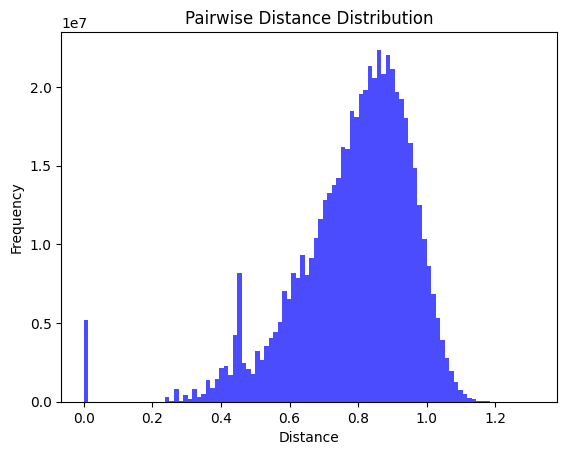

In [74]:

datasets["annomatic"]["topic_embedding"] = datasets["annomatic"]["topic_embedding"].fillna(datasets["annomatic"]["sentence_embedding"])


embeddings = np.stack(datasets["annomatic"]["topic_embedding"])
pairwise_distances = pdist(embeddings, metric='cosine')

deciles = np.percentile(pairwise_distances.ravel(), np.arange(0, 101, 10))
print(deciles)

mean_distance = np.mean(pairwise_distances)
std_distance = np.std(pairwise_distances)
min_distance = np.min(pairwise_distances)
max_distance = np.max(pairwise_distances)

print(f"Mean Distance: {mean_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Minimum Distance: {min_distance}")
print(f"Maximum Distance: {max_distance}")

plt.hist(pairwise_distances.ravel(), bins=100, color='blue', alpha=0.7)
plt.title("Pairwise Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [ ]:
def vendi_score_topic(embeddings):
    """
    Calculate Vendi Score for topic using cosine similarity between topic embeddings.
    """
    # Stack the embeddings into a matrix (n_samples, embedding_dim)
    cosine_sim_matrix = cosine_similarity(embeddings)
    vendi_score = vendi.score_K(cosine_sim_matrix)

    return vendi_score

def vendi_score_source(df):
    """
    Calculate Vendi Score for source dimension using Euclidean distance on reliability and bias.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'reliability' and 'bias' columns.

    Returns:
    - float: Vendi Score for sources.
    """
    features = df[['reliability', 'bias']].to_numpy()
    distances = np.sqrt(np.sum((features[:, np.newaxis] - features[np.newaxis, :]) ** 2, axis=-1))
    similarity_matrix = 1 / (1 + distances)
    return vendi.score_K(similarity_matrix)

Only 0 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 43 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
topic
4_fashion_gift_dress_skin    500
Name: count, dtype: int64
Only 73 sentences found within radius 0.0, retrying...
topic
0_israel_hamas_gaza_israeli    500
Name: count, dtype: int64
Only 1 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 0 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 304 sentences found within radius 0.0, retrying...
Only 1 sentences found within radius 0.0, retrying...
Only 0 sentences found within radius 0.0, retrying...
topic
0_israel_hamas_gaza_israeli    500
Name: count, dtype: int64
topic
8_food_chef_restaurant_sugar       

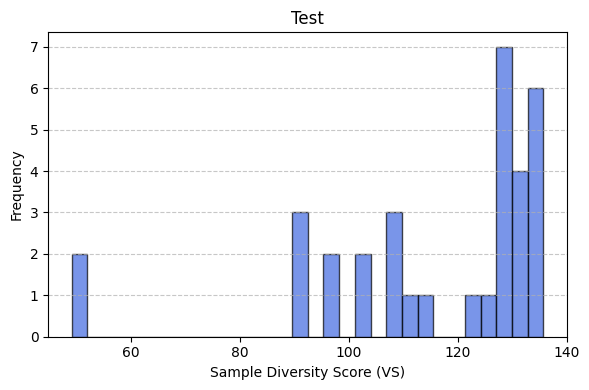

In [76]:
# Set a global random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


def sample_topics_within_radius(embeddings, radius, n_samples, iteration_seed=None):
    rng = np.random.default_rng(seed=iteration_seed)  # Local random generator
    
    while True:  # continue to try until it picks one with sufficient samples within radius
        random_index = rng.choice(len(embeddings))
        selected_embedding = embeddings[random_index].reshape(1, -1)

        # Calculate distances from the selected sentence
        distances = cosine_distances(embeddings, selected_embedding).ravel()

        # Find indices of sentences within the radius
        within_radius_indices = np.where(distances <= radius)[0]

        # Check if there are enough sentences to sample
        if len(within_radius_indices) >= n_samples:
            sampled_indices = rng.choice(within_radius_indices, n_samples, replace=False)
            return sampled_indices
        else:
            print(f"Only {len(within_radius_indices)} sentences found within radius {radius}, retrying...")

def plot_hist_vs(df, name):
    plt.figure(figsize=(6, 4))
    plt.hist(df["vs"], bins=30, color='royalblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Sample Diversity Score (VS)')
    plt.ylabel('Frequency')
    plt.title(name)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

vs_scores = []

for idx, n in enumerate(deciles): 
    for i in range(3):
        iteration_seed = random_seed + idx * 100 + i  # Unique seed per iteration
        sampled_indices = sample_topics_within_radius(embeddings, radius=n, n_samples=500, iteration_seed=iteration_seed)
        sampled_embeddings = np.stack(datasets["annomatic"].iloc[sampled_indices]["topic_embedding"].values)
        sent_sampled_embeddings = np.stack(datasets["annomatic"].iloc[sampled_indices]["sentence_embedding"].values)
        topics = datasets["annomatic"].iloc[sampled_indices]
        vs = vendi_score_topic(sent_sampled_embeddings)  # test if VS is more controll
        print(topics["topic"].value_counts(dropna=False))

        vs_scores.append({"radius": n, "iteration": i + 1, "vs": vs})

vs_scores = pd.DataFrame(vs_scores)
plot_hist_vs(vs_scores, "Test")


[ 0.          3.6435834   6.60730656  9.06302378 13.17808029 16.67058787
 20.35003931 24.51964519 28.66173756 36.12522941 51.11806139]
Mean Distance: 18.08655607954722
Standard Deviation: 11.888717526604006
Minimum Distance: 0.0
Maximum Distance: 51.11806138734137


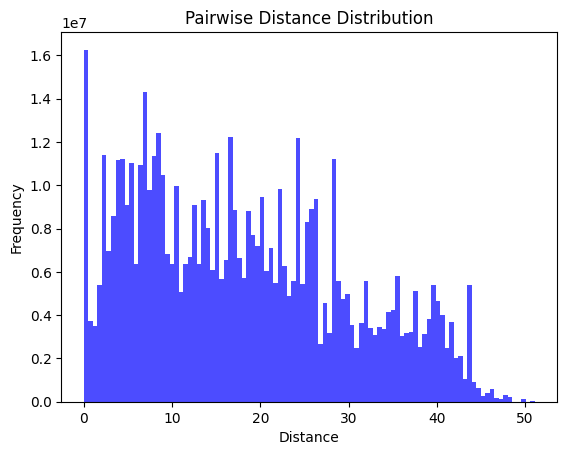

In [23]:
features = datasets["annomatic"][['reliability', 'bias']].to_numpy()
pairwise_distances = pdist(features, metric='euclidean')

deciles = np.percentile(pairwise_distances.ravel(), np.arange(0, 101, 10))
print(deciles)

mean_distance = np.mean(pairwise_distances)
std_distance = np.std(pairwise_distances)
min_distance = np.min(pairwise_distances)
max_distance = np.max(pairwise_distances)

print(f"Mean Distance: {mean_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Minimum Distance: {min_distance}")
print(f"Maximum Distance: {max_distance}")

plt.hist(pairwise_distances.ravel(), bins=100, color='blue', alpha=0.7)
plt.title("Pairwise Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

source
newsmax    500
Name: count, dtype: int64
source
alternet    500
Name: count, dtype: int64
Only 422 sources found within radius 0.0, retrying...
source
alternet    500
Name: count, dtype: int64
source
the-guardian           126
the-independent         51
the-conversation        44
the-verge               43
usa-today               28
npr                     24
cnet                    20
politico                15
cnn                     15
cbs-news                15
nbc-news                13
al-jazeera              12
poynter                 11
detroit-free-press      10
washington-blade        10
marketwatch              8
az-central               7
washington-post          7
quartz                   7
variety                  7
new-york-daily-news      6
fiscal-times             6
time-magazine            5
nowthis-news             3
business-insider         2
buzzfeed-news            2
education-week           2
heavy                    1
Name: count, dtype: int64
source
the-

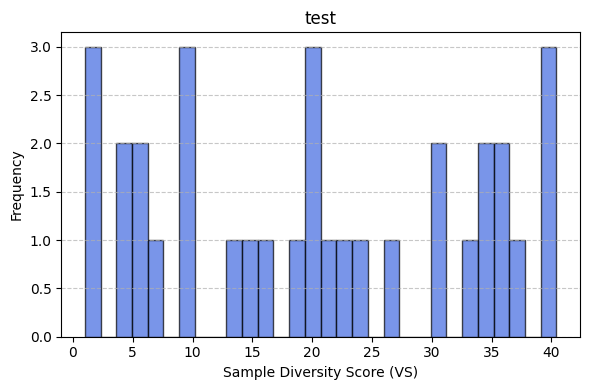

In [25]:
def sample_sources_within_radius(df, radius, n_samples, iteration_seed=None):
    rng = np.random.default_rng(seed=iteration_seed)  # Local random generator

    # Extract 'reliability' and 'bias' features
    features = df[['reliability', 'bias']].to_numpy()

    while True:
        # Randomly select an index
        random_index = rng.integers(len(features))
        selected_feature = features[random_index]

        # Calculate Euclidean distances from the selected source
        distances = np.linalg.norm(features - selected_feature, axis=1)

        # Find indices of sources within the radius
        within_radius_indices = np.where(distances <= radius)[0]

        # Check if there are enough sources to sample
        if len(within_radius_indices) >= n_samples:
            sampled_indices = rng.choice(within_radius_indices, n_samples, replace=False)
            return df.iloc[sampled_indices]
        else:
            print(f"Only {len(within_radius_indices)} sources found within radius {radius}, retrying...")

vs_scores = []

for idx, n in enumerate(deciles):
    for i in range(3):
        iteration_seed = random_seed + idx * 100 + i  # Unique seed per iteration
        sampled_indices = sample_sources_within_radius(datasets["annomatic"], radius=n, n_samples=500, iteration_seed=iteration_seed)

        vs = vendi_score_source(sampled_indices)  # test if VS is more controll
        print(sampled_indices["source"].value_counts())

        vs_scores.append({"radius": n, "iteration": i + 1, "vs": vs})

vs_scores = pd.DataFrame(vs_scores)
plot_hist_vs(vs_scores, f"test")

Do the distances with the topics embeddings instead of the sentences

In [66]:
# Extract topic embeddings and their corresponding topics
topics = list(annomatic_topics.keys())
embeddings = np.stack([annomatic_topics[topic] for topic in topics])

pairwise_distances = cdist(embeddings, embeddings, metric='euclidean')
deciles = np.percentile(pairwise_distances.ravel(), np.arange(0, 101, 10))

print(deciles)

mean_distance = np.mean(pairwise_distances)
std_distance = np.std(pairwise_distances)
min_distance = np.min(pairwise_distances)
max_distance = np.max(pairwise_distances)

print(f"Mean distance: {mean_distance:.4f}")
print(f"Standard deviation: {std_distance:.4f}")
print(f"Minimum distance: {min_distance:.4f}")
print(f"Maximum distance: {max_distance:.4f}")



[0.         0.57854274 0.62354179 0.65230594 0.67559371 0.69499402
 0.71534486 0.73516058 0.75778299 0.78801186 0.91088117]
Mean distance: 0.6846
Standard deviation: 0.1005
Minimum distance: 0.0000
Maximum distance: 0.9109


In [12]:
def sample_from_datasets_within_radius(data, radius, n_samples=500):
    topics = list(data.keys())
    embeddings = np.stack(list(data.values())) 

    while True:
        random_topic_idx = np.random.choice(len(topics))
        random_topic_embedding = embeddings[random_topic_idx]

        # Calculate distances to all other topic embeddings
        distances = np.linalg.norm(embeddings - random_topic_embedding, axis=1)

        # Find topics within the radius
        within_radius_indices = np.where(distances <= radius)[0]
        within_radius_topics = [topics[i] for i in within_radius_indices]

        # Filter the dataset for observations belonging to these topics
        filtered_data = datasets["annomatic"][datasets["annomatic"]["topic"].isin(within_radius_topics)]
        
        # Check if there are enough observations to sample
        if len(filtered_data) >= n_samples:
            sampled_observations = filtered_data.sample(n=n_samples, random_state=42)
            return sampled_observations

radius = 0.2
n_samples = 500



vs_scores= []

for n in np.arange(0.1, 1.1, 0.1):
    for i in range(3):
        sampled_observations = sample_from_datasets_within_radius(annomatic_topics, n, n_samples)
        sampled_embeddings = np.stack(sampled_observations["sentence_embedding"])
        vs = vendi_score_topic(sampled_embeddings) # test if VS is more controlled

        vs_scores.append({"radius": n, "iteration": i + 1, "vs": vs})
vs_scores = pd.DataFrame(vs_scores)
plot_hist_vs(vs_scores, f"test")


NameError: name 'annomatic_topics' is not defined